In [43]:
# Plotting ----

# Get all required packages

#%%
%load_ext autoreload
%autoreload 2

# Packages
import os
import rioxarray as rio
import pandas as pd
import geopandas as gpd

# Local modules
from mod_ra1_plots import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
# Option

do_plot_stats = False


In [45]:
# Directories
input_dir = '../data_input/'
output_dir = '../data_output/'

inversions = ['s76', 's81', 's85', 's93', 's99', 's06', 's10']

# Choose the list of inversion data version to analyse. Later (shorter) time series are driven by data from more stations.
inv_startyear = {'s76':1976, 's81':1981, 's85':1985, 's93': 1993, 's99':1999, 's06':2006, 's10':2010}  # Inversion version and starting year
# inv_startyear = {'s99':1999}

# Number of stations of each inversion version
inv_nstations = {'s76':9, 's81':14, 's85':21, 's93':35, 's99':49, 's06':59, 's10':78}

# List of strating years to define analysis periods
periods = [(1976,2021), (1981,2021), (1985,2021), (1993,2021), (1999,2021), (2006,2021), (2010,2021)]
# periods = [(1999,2021)]

In [46]:
if do_plot_stats:
    
    for inv in inv_startyear:

        inv_start = inv_startyear[inv]

        for period in periods:

            print('inv_start: ', inv_start)
            print('period: ', period)
        
            if(inv_start > period[0]):
                print('Continuing ...')
                continue

            print('Reading data: ', inv, ', period: ', period)

            ident = str(period[0])+'-'+str(period[1])+'_Inv'+str(inv_start)
            file_in_stats = os.path.join(output_dir, 'neeAmpStats_'+ident+'.nc')
            neeAmpStats = rio.open_rasterio(file_in_stats)

            # Map plot of flux trends
            plotLambert(xr_val=neeAmpStats.slope, ident=ident)

            # Plot slope with significance filter = 0.1
            # plotOrthoSig(xr_val=neeAmpStats.slope, ident=ident, p_lim=0.1, xr_pval=neeAmpStats.p_value, vmin=-0.08, vmax=0.08)

            # Plot slope without significance filter
            plotOrthoSig(xr_val=neeAmpStats.slope, ident=ident, p_lim=1, xr_pval=neeAmpStats.p_value, vmin=-0.08, vmax=0.08)

            # Plot variance without significance filter
            plotOrthoSig(xr_val=neeAmpStats.variance, ident=ident, p_lim=1, xr_pval=neeAmpStats.p_value, vmin=0, vmax=0.2, cmap='Oranges')

            

### Regional Analysis

Specific regions that coincide with NEE-amp trend or variance hotspots are selected for analysis.
A mask for selection is created by:

1. Clipping the data to the respective continent
2. Selecting the KG climate region that overlaps with the hotspot


In [47]:
# Regional Analysis
import shapely as sh

# Load the nee data to reproject_match other data ----
file_neeAmpStats = os.path.join(output_dir, 'neeAmpStats_2010-2021_Inv2010.nc')
neeAmp = rio.open_rasterio(file_neeAmpStats)

# Setup regions
kopp = rio.open_rasterio('../data_input/VU-VIENA/KG_1986-2010.grd', mask_and_scale=False)
kopp.rio.write_nodata(32, inplace=True)
kopp = kopp.where(kopp != kopp.rio.nodata)
kopp_rp = kopp.rio.reproject_match(neeAmp)

conts = gpd.read_file('../data_input/continents.geojson')
cont_bounds = {'Asia': [24,0,190,81], 'Europe': [-31, 35, 69, 81], 'North America': [-178, 0, -15, 84]}

# # Manual geometries
# geom_lat10_30 = sh.geometry.box(-179, 10, 179, 30)
# geom_lat30_50 = sh.geometry.box(-179, 30, 179, 50)
# geom_lat50_70 = sh.geometry.box(-179, 50, 179, 70)
# geom_lat70_90 = sh.geometry.box(-179, 70, 179, 90)
# geom_eastasia_tempwarm = sh.geometry.box(100, 20, 125, 35)
# geom_eastasia_tempcold = sh.geometry.box(115, 35, 135, 50)
geom_eastasia = sh.geometry.box(100, 0, 179, 90)
# geom_europe_temp = sh.geometry.box(-10, 40, 40, 55)
# geom_northamer_tempcold = sh.geometry.box(-130, 40. -50, 60)

# Create roi masks ---

roimask = dict()

cont = conts[conts['CONTINENT'] == 'Europe']
kopp_sel = kopp_rp.rio.clip(cont.geometry, cont.crs, all_touched=True, drop=False).squeeze()
# mask = kopp_sel.where(kopp_sel.isin([10])) # This would select the values instead of making a 0,1 mask
roimask['europe_temp'] = kopp_sel.isin([10])

cont = conts[conts['CONTINENT'] == 'Asia']
kopp_sel = kopp_rp.rio.clip([geom_eastasia], drop=False).rio.clip(cont.geometry, cont.crs, all_touched=True, drop=False).squeeze()
roimask['asia_tempwarm'] = kopp_sel.isin([9, 15])
roimask['asia_tempcold'] = kopp_sel.isin([6, 26, 27])

cont = conts[conts['CONTINENT'] == 'North America']
kopp_sel = kopp_rp.rio.clip(cont.geometry, cont.crs, all_touched=True, drop=False).squeeze()
roimask['northamer_tempcold'] = kopp_sel.isin([18, 19])


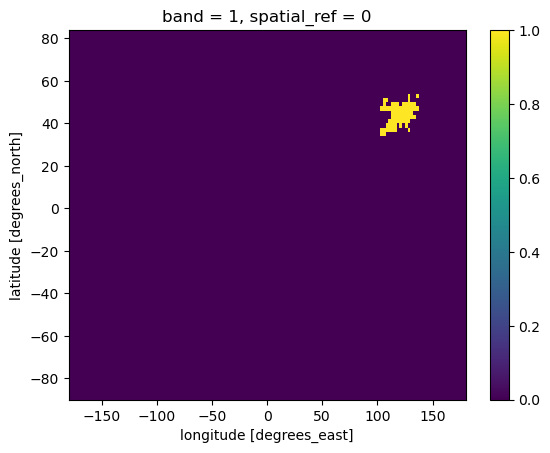

In [50]:
roimask['asia_tempcold'].plot()


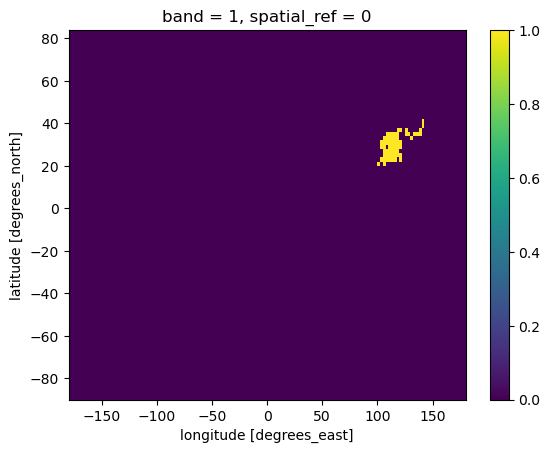

In [51]:
roimask['asia_tempwarm'].plot()


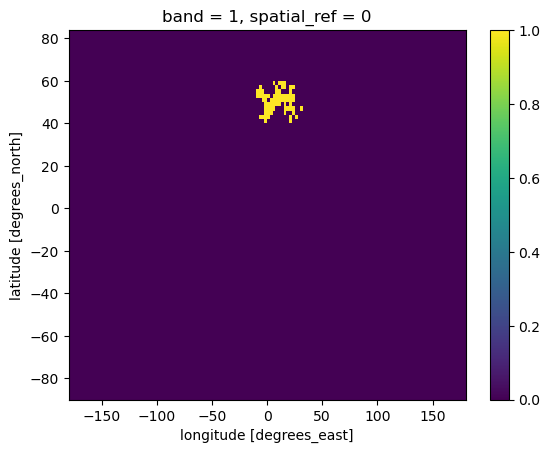

In [52]:
roimask['europe_temp'].plot()

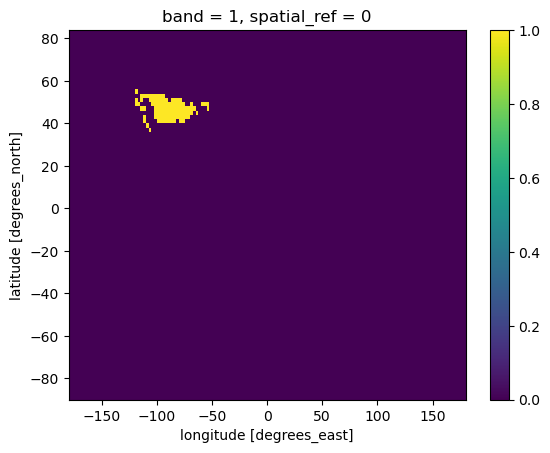

In [53]:
roimask['northamer_tempcold'].plot()

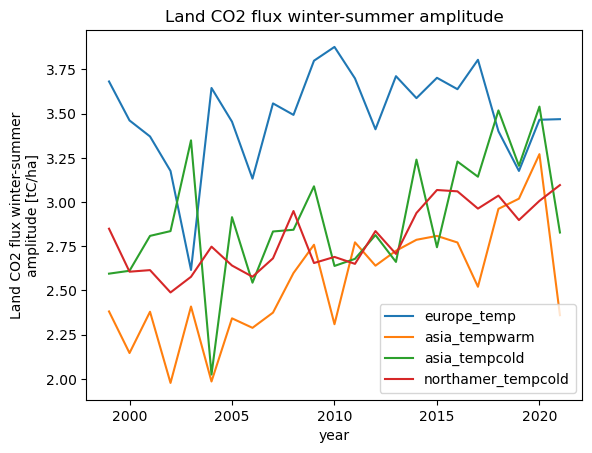

In [55]:
# Create a template dataframe to save results
# regind = np.unique(kopp.data[~np.isnan(kopp.data)]).astype(int)
# df_regions = pd.DataFrame({'regind': regind, 'regname': kopp_labels,
#                           'regcolor': kopp_cols, 'area': np.nan, 'co2amp_var': np.nan})

# Choose the list of inversion data version to analyse. Later (shorter) time series are driven by data from more stations.
# inv_startyear = {'s76':1976, 's81':1981, 's85':1985, 's93': 1993, 's99':1999, 's06':2006, 's10':2010}  # Inversion version and starting year
inv_startyear = {'s99':1999} 

# List of strating years to define analysis periods
# periods = [(1976,2021), (1981,2021), (1985,2021), (1993,2021), (1999,2021), (2006,2021), (2010,2021)]
periods = [(1999,2021)]
  
for inv in inv_startyear:

    inv_start = inv_startyear[inv]

    ident = 'Inv'+str(inv_start)

    file_in_amp = os.path.join(output_dir, 'neeAmp_Inv'+str(inv_start)+'.nc')
    neeAmp = rio.open_rasterio(file_in_amp)

    # Clip to the roi

    plotRegMeans(xr_val=neeAmp, regions=roimask, ident=ident)


    # Plotting of seasonal amplitude time series
    # plotLatMeans(xr_val=neeAmp, lats=([30, 50], [50, 70], [70, 90]), ident='Inv'+str(inv_start))

    # regDiffMean = xr_val.where(xr_val.y > lat[0]).where(xr_val.y < lat[1]).mean(['x','y'])


    # if inv_start == inv_startyear[0]:
        
    #     reg_ts = pd.DataFrame(neeAmp)
